<h1 style = "font-size:3rem;color:darkcyan"> Music genre classication - Train CNN Model </h1>

In [1]:
# import libraries
import numpy as np
import tensorflow as tf
import json
from sklearn.model_selection import train_test_split
import sklearn
import matplotlib.pyplot as plt

In [36]:
# importing dataset (.json)
def import_dataset_for_CNN(dataset_path):
    
    # open json file
    with open(dataset_path, 'r') as f:
        data = json.load(f)
    
    # split list into different np arrays
    mappings = np.array(data['mappings']) 
    inputs = np.array(data['MFCC'])
    targets = np.array(data['labels'])
    filenames = np.array(data['filenames'])
    
    return mappings, inputs, targets, filenames

In [37]:
mappings, inputs, targets, filenames = import_dataset('data.json')

In [39]:
# Add channel dimension for CNN --> 4D matrix
inputs = inputs[..., np.newaxis]
inputs.shape

(9981, 130, 13, 1)

In [131]:
def train_val_test_split(x, y, filenames, test_size = 0.25, val_size = 0.2):
    if (0 < test_size < 1)  and (0 < val_size < 1):
        train_size = 1 - test_size - val_size
        if train_size > 0:

            # train test split
            (
            x_train, x_test, 
            y_train, y_test,
            fn_train, fn_test
            ) = train_test_split(x, y, filenames, test_size = test_size)

            #train validation split
            (
            x_train, x_val, 
            y_train, y_val, 
            fn_train, fn_val
            ) = train_test_split(x_train, y_train, fn_train, test_size = val_size)

            return x_train, x_val, x_test, y_train, y_val, y_test, fn_train, fn_val, fn_test
        else: 
            print('train size is too small, adjust test and validation sizes')
            return
    else:
        print('test and validation size should be between 0 and 1!')
        return

In [132]:
# split data into train, validation and test sets
(
x_train, x_val, x_test,
y_train, y_val, y_test,
fn_train, fn_val, fn_test
) = train_val_test_split(inputs, targets, filenames, test_size = 0.25, val_size = 0.2)

In [134]:
x_train.shape

(5988, 130, 13, 1)

In [135]:
def build_CNN_model(input_shape, output_len):
    # create model
    model = tf.keras.Sequential()
    
    # 1st conv layer
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # 2nd conv layer
    model.add(tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D((3,3), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # 3rd conv layer
    model.add(tf.keras.layers.Conv2D(32, (2,2), activation = 'relu', input_shape = input_shape))
    model.add(tf.keras.layers.MaxPool2D((2,2), strides = (2,2), padding = 'same'))
    model.add(tf.keras.layers.BatchNormalization())
    
    # flatten the output layer and feed into dense later
    model.add(tf.keras.layers.Flatten())
    model.add(tf.keras.layers.Dense(64, activation = 'relu'))
    model.add(tf.keras.layers.Dropout(0.3))
    
    # output layer with softmax
    model.add(tf.keras.layers.Dense(output_len, activation = 'softmax'))
    
    return model

In [137]:
# build model
input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])
model = build_CNN_model(input_shape, len(mappings))

In [138]:
learning_rate = 0.0001
optimizer = tf.keras.optimizers.Adam(learning_rate)
model.compile(optimizer = optimizer,
             loss='sparse_categorical_crossentropy',
             metrics = ['accuracy'])


In [139]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 128, 11, 32)       320       
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 64, 6, 32)        0         
 g2D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 64, 6, 32)        128       
 chNormalization)                                                
                                                                 
 conv2d_25 (Conv2D)          (None, 62, 4, 32)         9248      
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 31, 2, 32)        0         
 g2D)                                                            
                                                      

In [140]:
history = model.fit(x_train, y_train,
                   validation_data = (x_val, y_val),
                   batch_size = 32, 
                   epochs = 30)

Epoch 1/30
188/188 [==============================] - 4s 15ms/step - loss: 2.3677 - accuracy: 0.2331 - val_loss: 1.8510 - val_accuracy: 0.3614
Epoch 2/30
188/188 [==============================] - 3s 15ms/step - loss: 1.8745 - accuracy: 0.3580 - val_loss: 1.5722 - val_accuracy: 0.4603
Epoch 3/30
188/188 [==============================] - 3s 14ms/step - loss: 1.6672 - accuracy: 0.4180 - val_loss: 1.4326 - val_accuracy: 0.4977
Epoch 4/30
188/188 [==============================] - 3s 15ms/step - loss: 1.5433 - accuracy: 0.4547 - val_loss: 1.3638 - val_accuracy: 0.5110
Epoch 5/30
188/188 [==============================] - 3s 14ms/step - loss: 1.4359 - accuracy: 0.4947 - val_loss: 1.2835 - val_accuracy: 0.5491
Epoch 6/30
188/188 [==============================] - 3s 14ms/step - loss: 1.3685 - accuracy: 0.5062 - val_loss: 1.2429 - val_accuracy: 0.5498
Epoch 7/30
188/188 [==============================] - 3s 14ms/step - loss: 1.3333 - accuracy: 0.5259 - val_loss: 1.1939 - val_accuracy: 0.5832

In [141]:
def plot_training_history(history, figsize = [15,6]):
    
    fig, ax = plt.subplots(2, figsize=figsize)
    
    # create accuracy subplot
    ax[0].plot(history.history['accuracy'], label = 'Training Accuracy')
    ax[0].plot(history.history['val_accuracy'], label = 'Validation Accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].legend(loc='lower right')
    ax[0].set_title('Accuracy Evaluation')
    
    # create error subplot
    ax[1].plot(history.history['loss'], label = 'Training Error')
    ax[1].plot(history.history['val_loss'], label = 'Validation Error')
    ax[1].set_ylabel('Error')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(loc='upper right')
    ax[1].set_title('Error Evaluation')
    
    plt.show()

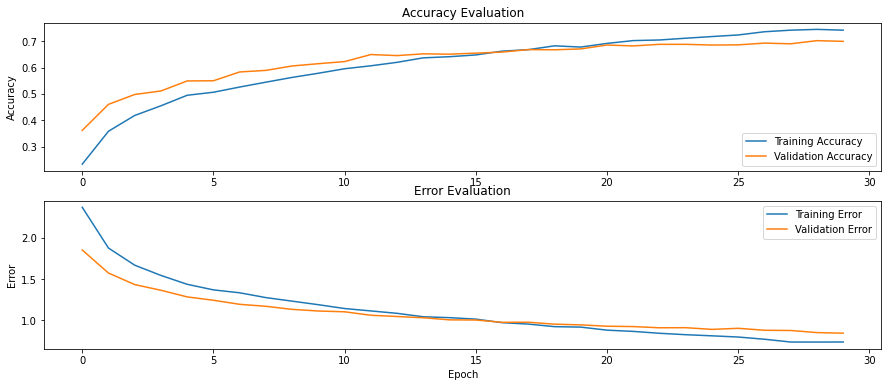

In [142]:
plot_training_history(history)

In [143]:
# test model using test data
test_error, test_accuracy = model.evaluate(x_test, y_test, verbose = True)

78/78 [==============================] - 0s 4ms/step - loss: 0.8527 - accuracy: 0.7023


In [144]:
# prediction
y_pred = model.predict(x_test)
pred_classes = np.argmax(y_pred, axis=1)

78/78 [==============================] - 0s 4ms/step


In [145]:
# visualize confusion matrix

def plot_confusion_matrix(true_target, predicted_target, classes, normalize = None, cmap= 'PuBu', size = [6,6], fontsize=9):
    # get confusion matrix
    labels = np.arange(0,len(classes), 1)
    cm = sklearn.metrics.confusion_matrix(true_target, predicted_target, labels = labels)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        title = 'Normalized Confusion Matrix'
    else:
        title = 'Absolute Confusion Matrix'
        
    fig, ax = plt.subplots(figsize=size)
    im = ax.imshow(cm, interpolation='nearest', cmap= cmap)
    ax.figure.colorbar(im, ax=ax)
    
    
    # set labels ticks
    ticks = np.arange(cm.shape[1])
    ax.set(xticks=ticks,
           yticks=ticks,
           xticklabels=classes, 
           yticklabels=classes,
          )
    
    ax.set_title(title, fontsize = 20)
    ax.set_ylabel('True Class', fontsize = fontsize)
    ax.set_xlabel('Predicted Class', fontsize = fontsize)
     
    # style tick labels
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor", color = 'darkgrey', fontsize = fontsize)
    plt.setp(ax.get_yticklabels(), ha="right",
             rotation_mode="anchor", color = 'darkgrey', fontsize = fontsize)
    
    # plot text annotation inside each segment
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black",
                    fontsize = fontsize)

    fig.tight_layout()
    plt.show()

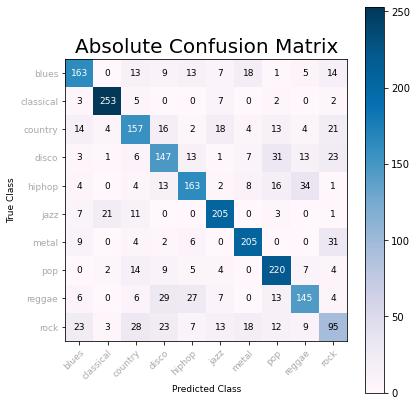

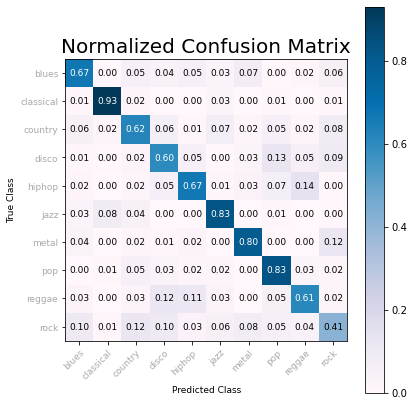

In [146]:
plot_confusion_matrix(y_test, pred_classes, classes = mappings, size = [6,6], normalize = False)
plot_confusion_matrix(y_test, pred_classes, classes = mappings, size = [6,6], normalize = True)

In [158]:
len(pred_classes)
len(y_test)

print(len(y_test == pred_classes))

2496


In [168]:
#displaying names of misclassified files
for i in range(len(y_test)):
    if pred_classes[i] != y_test[i]:
        print('{: <20} classified as {}'.format(fn_test[i], mappings[pred_classes[i]]))
        


rock.00003.wav       classified as blues
rock.00094.wav       classified as metal
metal.00066.wav      classified as blues
hiphop.00075.wav     classified as reggae
pop.00041.wav        classified as country
country.00062.wav    classified as disco
hiphop.00066.wav     classified as reggae
rock.00013.wav       classified as hiphop
rock.00027.wav       classified as country
country.00081.wav    classified as disco
blues.00011.wav      classified as jazz
hiphop.00030.wav     classified as disco
rock.00012.wav       classified as reggae
rock.00011.wav       classified as blues
country.00055.wav    classified as rock
disco.00050.wav      classified as rock
country.00033.wav    classified as disco
country.00005.wav    classified as pop
hiphop.00029.wav     classified as disco
rock.00078.wav       classified as country
reggae.00044.wav     classified as hiphop
hiphop.00062.wav     classified as reggae
rock.00077.wav       classified as disco
disco.00023.wav      classified as pop
blues.00074